In [3]:
#Importing the libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from IPython.display import display
import random

#from tqdm import *

Using TensorFlow backend.


In [4]:
# log progress for time consuming loops
#
# PROJECT IN GIT: https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [5]:
#Reading the traning file
train = pd.read_csv('./data/train_2.csv').fillna(0)
page = train['Page']
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [6]:
#the Page colum is not neccesary for training the model
train=train.drop('Page',axis=1)
train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [48]:
# how many days will you get to predict your model
INPUT_DAYS = 5
# number of days in future model will try to predict
OUTPUT_DAYS = 10
# number of days used to train
WINDOW_RANGE = 500
# test range
TEST_RANGE = 60
# number of shift for val data
SHIFT_VAL = 90

def createLSTMModel():
    regressor = Sequential()
    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(input_shape = (INPUT_DAYS, 1), units=30, return_sequences=True))
    regressor.add(Dropout(0.5))
    regressor.add(LSTM(256))
    regressor.add(Dropout(0.25))

    # Adding the output layer
    regressor.add(Dense(units = 1))
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

def createLSTMModelOld():
    regressor = Sequential()
    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 24, activation = 'relu', input_shape = (INPUT_DAYS, 1)))
    # Adding the output layer
    regressor.add(Dense(units = 1))
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

def createRegressionModel():
    model = Sequential()
    model.add(Dense(4, input_dim=INPUT_DAYS, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

def calculateError(y_test, y_pred):
    rms = np.sqrt(mean_squared_error(y_test, y_pred))
    return rms

In [49]:
rows_values = list()
for i in range(0,1000):
    X_value = random.randint(0,train.shape[0])
    #print(X_value)
    rows_values.append(X_value)
print(rows_values)

#rows_values = [32282, 60282, 129719, 126098, 144483, 38573, 39637, 58771, 130389, 138748, 125464, 38416,
#               103434, 15958, 3451, 41072, 75127, 37290, 16489]
#rows_values = range(0,train.shape[0])

[5466, 142079, 74840, 24341, 9736, 104766, 98709, 71839, 35949, 79878, 95490, 51614, 50783, 5600, 1474, 123275, 126951, 48916, 111207, 130011, 59990, 38718, 69524, 38999, 96233, 89599, 10083, 4075, 105324, 1727, 91625, 53223, 134520, 108917, 18525, 56184, 141227, 135234, 75177, 16023, 122380, 112019, 3286, 101234, 10042, 117540, 139332, 64539, 131408, 20545, 114276, 51733, 124436, 127840, 53601, 143523, 51573, 50523, 71199, 90110, 51899, 5585, 39133, 106543, 19802, 8568, 61143, 136108, 14074, 92489, 53967, 69243, 53029, 2933, 52189, 114896, 125931, 53330, 46364, 77256, 37650, 67373, 72260, 99585, 114274, 81087, 86285, 59754, 90985, 58051, 31716, 77247, 62386, 113722, 143602, 53669, 73589, 118317, 131270, 32226, 142761, 83195, 79787, 57877, 2523, 89255, 31501, 30599, 141833, 59420, 73083, 128207, 88306, 360, 12898, 94950, 84193, 9598, 143321, 18786, 100199, 104956, 92888, 96412, 19813, 124691, 4963, 109116, 83997, 129716, 98209, 25932, 119057, 14366, 76450, 91314, 101577, 118801, 106195

In [50]:
# get Train, Validation and Test data

X_train = np.empty((0,INPUT_DAYS))
Y_train = np.empty((0,OUTPUT_DAYS))
X_val = np.empty((0,INPUT_DAYS))
Y_val = np.empty((0,OUTPUT_DAYS))
for row in log_progress(rows_values, every=1):
    train_row = train.iloc[row,:].values

    X_train1 = np.reshape(train_row[0:WINDOW_RANGE],(-1,1))
    X_val1 = np.reshape(train_row[SHIFT_VAL:WINDOW_RANGE+SHIFT_VAL],(-1,1))
    for i in range(1,INPUT_DAYS):
        x_train1 = train_row[i:WINDOW_RANGE+i]
        X_train1 = np.append(X_train1, np.reshape(x_train1,(-1,1)), axis=1)
        x_val1 = train_row[i+SHIFT_VAL:WINDOW_RANGE+i+SHIFT_VAL]
        X_val1 = np.append(X_val1, np.reshape(x_val1,(-1,1)), axis=1)

    Y_train1 = np.reshape(train_row[INPUT_DAYS:WINDOW_RANGE+INPUT_DAYS],(-1,1))
    Y_val1 = np.reshape(train_row[INPUT_DAYS+SHIFT_VAL:WINDOW_RANGE+INPUT_DAYS+SHIFT_VAL],(-1,1))
    for i in range(INPUT_DAYS+1, INPUT_DAYS+OUTPUT_DAYS):
        y_train1 = train_row[i:WINDOW_RANGE+i]
        Y_train1 = np.append(Y_train1, np.reshape(y_train1,(-1,1)), axis=1)
        y_val1 = train_row[i+SHIFT_VAL:WINDOW_RANGE+i+SHIFT_VAL]
        Y_val1 = np.append(Y_val1, np.reshape(y_val1,(-1,1)), axis=1)
    
    X_train = np.append(X_train, X_train1, axis=0)
    Y_train = np.append(Y_train, Y_train1, axis=0)
    X_val = np.append(X_val, X_val1, axis=0)
    Y_val = np.append(Y_val, Y_val1, axis=0)

# Feature Scaling
sc_X = MinMaxScaler(feature_range=(0, 1000))
sc_Y = MinMaxScaler(feature_range=(0, 1000))
X_train = sc_X.fit_transform(X_train)
Y_train = sc_Y.fit_transform(Y_train)
X_val = sc_X.transform(X_val)
Y_val = sc_Y.transform(Y_val)

#print(X_train.shape)
#print(Y_train.shape)

# Shuffle data in training dataset
train_data = np.append(X_train, Y_train, axis=1)
train_data = shuffle(train_data)
X_train = train_data[:,0:INPUT_DAYS]
Y_train = train_data[:,INPUT_DAYS:INPUT_DAYS+OUTPUT_DAYS+1]
#print(X_train.shape)
#print(Y_train.shape)

In [43]:
# save dataset
#np.savetxt("X_train.csv", X_train, delimiter=",")
#np.savetxt("Y_train.csv", Y_train, delimiter=",")
#np.savetxt("X_val.csv", X_val, delimiter=",")
#np.savetxt("Y_val.csv", Y_val, delimiter=",")

# or read if it is already saved
#X_train = pd.read_csv('./data_10000R_30i_5o/X_train.csv')
#Y_train = pd.read_csv('./data_10000R_30i_5o/Y_train.csv')
#X_val = pd.read_csv('./data_10000R_30i_5o/X_val.csv')
#Y_val = pd.read_csv('./data_10000R_30i_5o/Y_val.csv')

In [52]:
#Reshaping Array for Regression
#X_train = np.reshape(X_train, (WINDOW_RANGE*len(rows_values),INPUT_DAYS))
#X_val = np.reshape(X_val, (WINDOW_RANGE*len(rows_values),INPUT_DAYS))
#Reshaping Array for LSTM
X_train = np.reshape(X_train, (WINDOW_RANGE*len(rows_values),INPUT_DAYS,1))
X_val = np.reshape(X_val, (WINDOW_RANGE*len(rows_values),INPUT_DAYS,1))

# Initialising the RNN
regressors = []
for i in range(0,OUTPUT_DAYS):
    print("Generating model for day " + str(i))
    regressor = createLSTMModel()

    # Fitting the RNN to the Training set
    regressor.fit(X_train, Y_train[:,i], 
                  batch_size = 1024, 
                  epochs = 3, 
                  verbose = 1, 
                  validation_data=(X_val, Y_val[:,i]))
    regressors.append(regressor)

Generating model for day 0
Train on 500000 samples, validate on 500000 samples
Epoch 1/3
  1024/500000 [..............................] - ETA: 53:50 - loss: 10.2478

KeyboardInterrupt: 

70476


'Root Mean Square - Pred 1: 92.7233250117049'

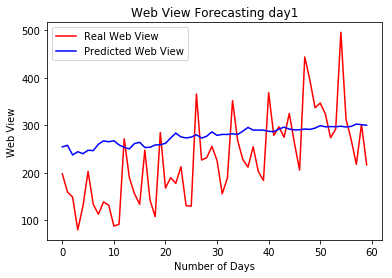

'Root Mean Square - Pred 2: 132.1956725626258'

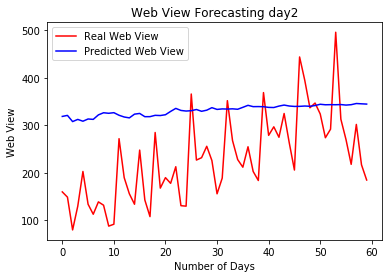

'Root Mean Square - Pred 3: 79.0872058439013'

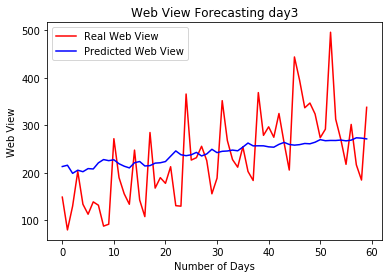

'Root Mean Square - Pred 4: 94.32071225057207'

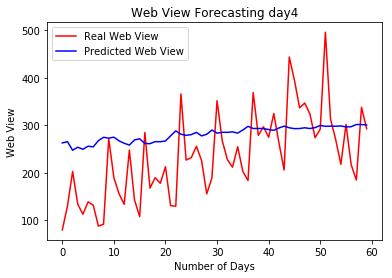

'Root Mean Square - Pred 5: 103.20779582852835'

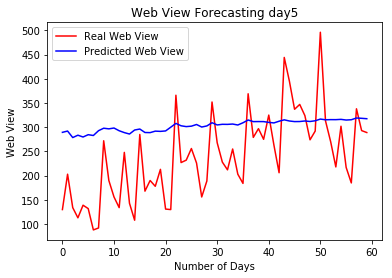

In [45]:
X_value = random.choice(rows_values)
print(X_value)

# Getting the predicted Web View
test_row = train.iloc[X_value,:].values
test_row = test_row[WINDOW_RANGE+INPUT_DAYS+OUTPUT_DAYS:]

X_test = np.reshape(test_row[0:TEST_RANGE],(-1,1))
for i in range(1,INPUT_DAYS):
    x_test = test_row[i:TEST_RANGE+i]
    X_test = np.append(X_test, np.reshape(x_test,(-1,1)), axis=1)
    
y_test = np.reshape(test_row[INPUT_DAYS:TEST_RANGE+INPUT_DAYS],(-1,1))
for i in range(INPUT_DAYS+1, INPUT_DAYS+OUTPUT_DAYS):
    y = test_row[i:TEST_RANGE+i]
    y_test = np.append(y_test, np.reshape(y,(-1,1)), axis=1)

inputs = X_test
inputs = sc_X.transform(inputs)

# reshape for Regression
#inputs = np.reshape(inputs, (TEST_RANGE, INPUT_DAYS))
# reshape for LSTM
inputs = np.reshape(inputs, (TEST_RANGE, INPUT_DAYS,1))

Y_pred = np.empty((TEST_RANGE,0))
for i in range(0,OUTPUT_DAYS):
    regressor = regressors[i]
    y_pred = regressor.predict(inputs)
    #y_pred = sc_Y.inverse_transform(y_pred)
    #y_pred[y_pred < 0] = 0
    Y_pred = np.append(Y_pred, np.reshape(y_pred, (TEST_RANGE,1)), axis=1)

    #print(y_pred)
    
Y_pred = sc_Y.inverse_transform(Y_pred)
Y_pred[Y_pred < 0] = 0

#print(Y_pred)

for i in range(0,OUTPUT_DAYS):
    error = calculateError(y_test[:,i], Y_pred[:,i])
    
    display("Root Mean Square - Pred " + str(i+1) + ": " + str(error))

    #Visualising Result
    plt.figure
    plt.plot(y_test[:,i], color = 'red', label = 'Real Web View')
    plt.plot(Y_pred[:,i], color = 'blue', label = 'Predicted Web View')
    #plt.plot(X_test, color = 'green', label = 'Previous values')
    plt.title('Web View Forecasting day' + str(i+1))
    plt.xlabel('Number of Days')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()

In [46]:
# calculate aggregated error for data
# As it will take too long to calculate error to all pages and, most of the RMS error would come from
# high access pages, we will only check error in the top-1000 accessed pages.
# You need to run Cluster file before running this one.

#top_pages = pd.read_csv('data_fil_sorted.csv')
#top_indexes = top_pages.iloc[0:1000,0].values

all_errors = np.empty((0,OUTPUT_DAYS))
#for row in log_progress(range(0,train.shape[0]), every=1):
for row in log_progress(rows_values, every=1):
    # Getting the predicted Web View
    test_row = train.iloc[row,:].values
    test_row = test_row[WINDOW_RANGE+INPUT_DAYS+OUTPUT_DAYS:]

    X_test = np.reshape(test_row[0:TEST_RANGE],(-1,1))
    for i in range(1,INPUT_DAYS):
        x_test = test_row[i:TEST_RANGE+i]
        X_test = np.append(X_test, np.reshape(x_test,(-1,1)), axis=1)

    y_test = np.reshape(test_row[INPUT_DAYS:TEST_RANGE+INPUT_DAYS],(-1,1))
    for i in range(INPUT_DAYS+1, INPUT_DAYS+OUTPUT_DAYS):
        y = test_row[i:TEST_RANGE+i]
        y_test = np.append(y_test, np.reshape(y,(-1,1)), axis=1)

    inputs = X_test
    inputs = sc_X.transform(inputs)

    # reshape for Regression
    #inputs = np.reshape(inputs, (TEST_RANGE, INPUT_DAYS))
    # reshape for LSTM
    inputs = np.reshape(inputs, (TEST_RANGE, INPUT_DAYS,1))

    Y_pred = np.empty((TEST_RANGE,0))
    for i in range(0,OUTPUT_DAYS):
        regressor = regressors[i]
        y_pred = regressor.predict(inputs)
        #y_pred = sc_Y.inverse_transform(y_pred)
        #y_pred[y_pred < 0] = 0
        Y_pred = np.append(Y_pred, np.reshape(y_pred, (TEST_RANGE,1)), axis=1)

    Y_pred = sc_Y.inverse_transform(Y_pred)
    Y_pred[Y_pred < 0] = 0
    
    errors = np.empty((1,OUTPUT_DAYS))
    for j in range(0,OUTPUT_DAYS):
        error = calculateError(y_test[:,j], Y_pred[:,j])
        errors[0,j] = error
        
    all_errors = np.append(all_errors, errors, axis=0)

[388.29340846 392.56497334 402.72558097 380.0185693  374.32526191]


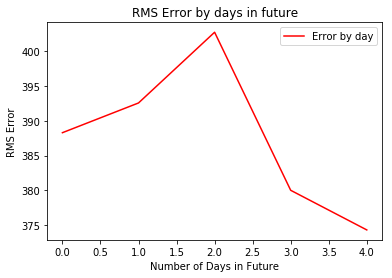

In [47]:
mean_errors = np.mean(all_errors, axis=0)
print(mean_errors)

#Visualising Total RMS Error by future prediction day
plt.figure
plt.plot(mean_errors, color = 'red', label = 'Error by day')
plt.title('RMS Error by days in future')
plt.xlabel('Number of Days in Future')
plt.ylabel('RMS Error')
plt.legend()
plt.savefig("data.png")
plt.show()